# DSCI 100 Group 177 - Group Project Proposal

### Title: Predicting the round of a tennis tournament based on the match participants' rankings and ranking points using match data from the year 2019

In [3]:
# Please run this cell before continuing, installing packages if necessary.
library(tidyverse)
library(RColorBrewer)
library(tidymodels)

### Introduction:

**Background:** Throughout the year, the Association of Tennis Professionals (ATP) holds many single-elimination tournaments, and uses a merit-based method to rank all professional men’s tennis players based on their performances in ATP-sanctioned tournaments over the previous 12 months. The farther a player progresses in a tournament (and the more important and/or prestigious a tournament is), the more points they will gain in the rankings, which are updated weekly. Therefore, each player has both a ranking and a number of points which determines their ranking relative to others (for example, at the time of submission, Carlos Alcaraz is ranked #1 in the world and has 6,730 points). Important to note is that in each tournament, a draw (or bracket) is set up which ensures that highly-ranked players are not likely to meet each other too early in the tournament, making it more likely that the later rounds will include highly-ranked players playing one another.

**Our question:** We would like to attempt to predict the round of a tennis tournament (final, semi-final, quarter-final, round of 16, etc.) in which a match occurs using predictor variables such as the ranks of the winner and loser, as well as their points in the ATP rankings. In order to find the best predictors to use apart from those already identified, we will use a method such as forward selection to  evaluate the accuracy when using several different subsets of predictors.

**Our dataset:** The dataset we will be using contains all of the match results for matches involving the 500 top players in the ATP rankings from the years 2017-2019, with each row/observation corresponding to one match. The data for each match includes many statistics, such as the competitors’ identities, rankings, ranking points, the round of the tournament in which the match occurred, and other metrics concerning the performance of the players in the match. We will only be using data from the year 2019, and for matches that are part of a single-elimination tournament.

### Preliminary exploratory data analysis:

In [16]:
tennis_data <- read_csv("https://raw.githubusercontent.com/ben-westmore/dsci-100-2022w1-group-177/main/atp2017-2019.csv") |>
    mutate(round = as_factor(round),
           tourney_year = as.double(substr(tourney_date, 1, 4)),
           tourney_month = as.double(substr(tourney_date, 5, 6)),
           tourney_day = as.double(substr(tourney_date, 7, 8))) |>
    filter(round != 'BR',
           round != 'RR',
           tourney_year == 2019) |>
    select(-1, -tourney_date)

tennis_data <- tennis_data[, c(1:5, 49:51, 6:48)]    

head(tennis_data)
glimpse(tennis_data)

tennis_data$round <- factor(tennis_data$round, levels = c("F", "SF", "QF", "R16", "R32", "R64", "R128"))
levels(tennis_data$round)

tennis_split <- initial_split(tennis_data, prop = 0.75, strata = round)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_year,tourney_month,tourney_day,match_num,winner_id,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-0301,Auckland,Hard,32,A,2019,1,7,300,105815,⋯,39,23,11,9,8,12,63,814,93,616
2019-0301,Auckland,Hard,32,A,2019,1,7,299,111815,⋯,61,45,13,15,7,10,93,616,58,855
2019-0301,Auckland,Hard,32,A,2019,1,7,298,105815,⋯,36,24,10,9,5,8,63,814,34,1125
2019-0301,Auckland,Hard,32,A,2019,1,7,297,111815,⋯,52,36,13,10,4,5,93,616,50,933
2019-0301,Auckland,Hard,32,A,2019,1,7,296,105526,⋯,104,72,23,18,13,15,58,855,24,1705
2019-0301,Auckland,Hard,32,A,2019,1,7,295,105815,⋯,40,27,18,10,6,7,63,814,54,895


Rows: 2,357
Columns: 51
$ tourney_id         <chr> "2019-0301", "2019-0301", "2019-0301", "2019-0301",…
$ tourney_name       <chr> "Auckland", "Auckland", "Auckland", "Auckland", "Au…
$ surface            <chr> "Hard", "Hard", "Hard", "Hard", "Hard", "Hard", "Ha…
$ draw_size          <dbl> 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,…
$ tourney_level      <chr> "A", "A", "A", "A", "A", "A", "A", "A", "A", "A", "…
$ tourney_year       <dbl> 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 201…
$ tourney_month      <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ tourney_day        <dbl> 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, …
$ match_num          <dbl> 300, 299, 298, 297, 296, 295, 294, 293, 292, 289, 2…
$ winner_id          <dbl> 105815, 111815, 105815, 111815, 105526, 105815, 104…
$ winner_seed        <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "2"…
$ winner_entry       <chr> NA, "WC", NA, "WC", NA, NA, NA, NA, "WC", NA, NA, N…
$ winner_name   

[1] "F"    "SF"   "QF"   "R16"  "R32"  "R64"  "R128"

round,number_of_matches
<fct>,<int>
F,47
SF,95
QF,194
R16,337
R32,595
R64,278
R128,220


Warning message:
“Removed 143 rows containing missing values (geom_point).”


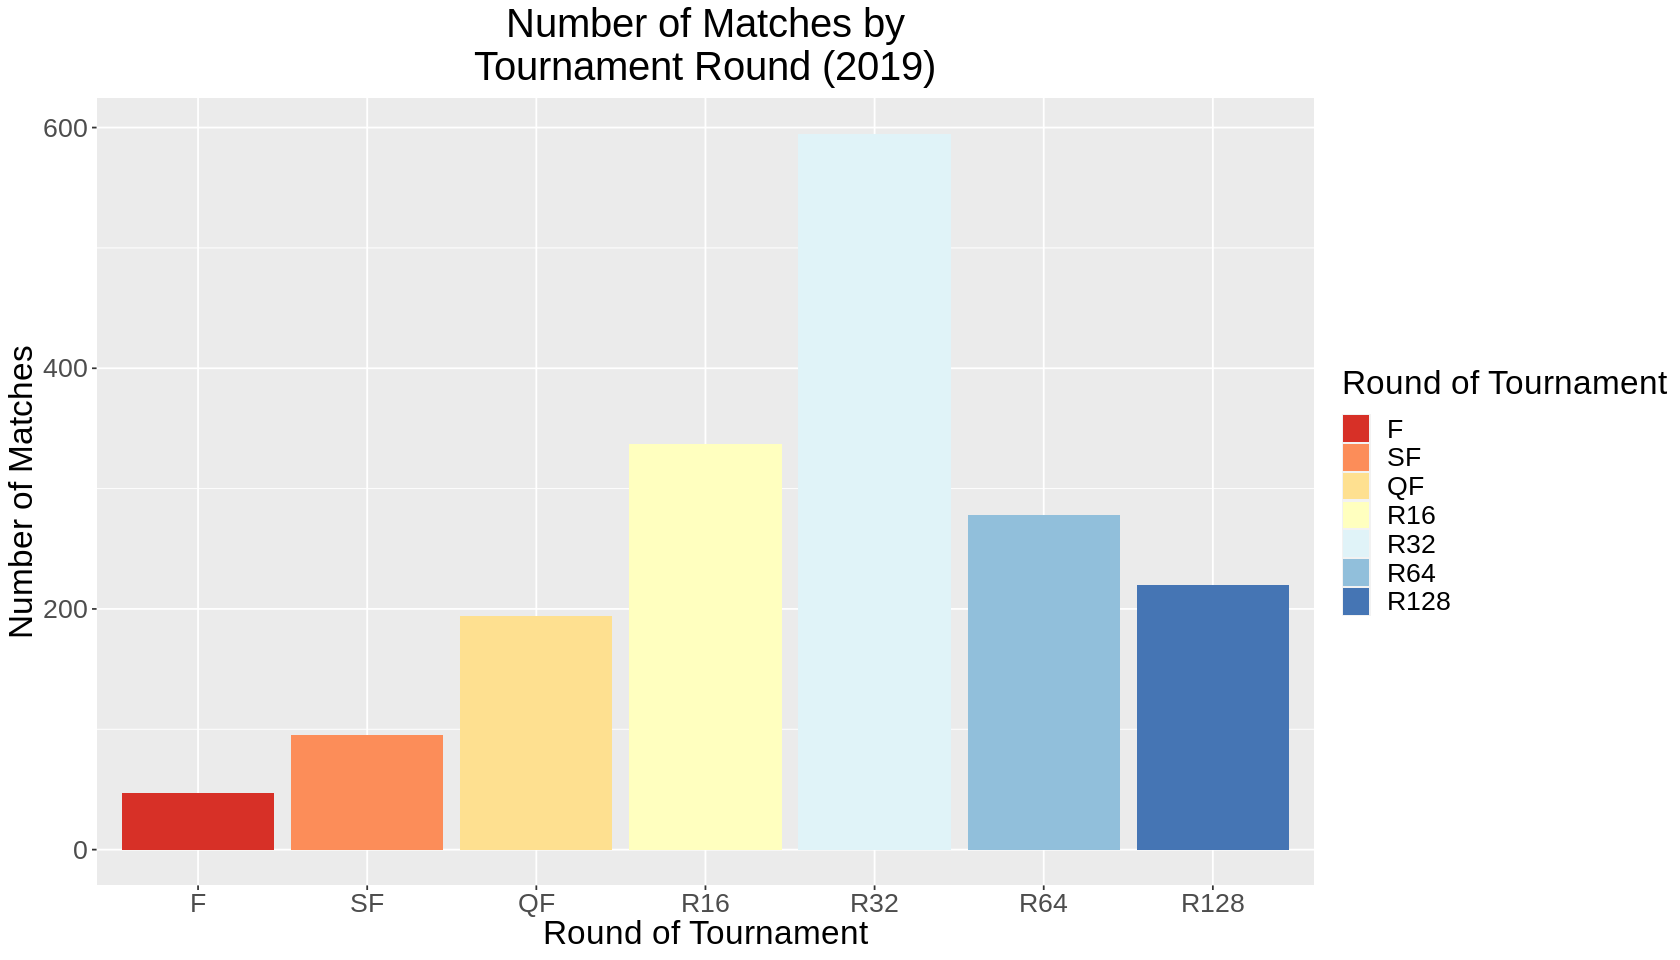

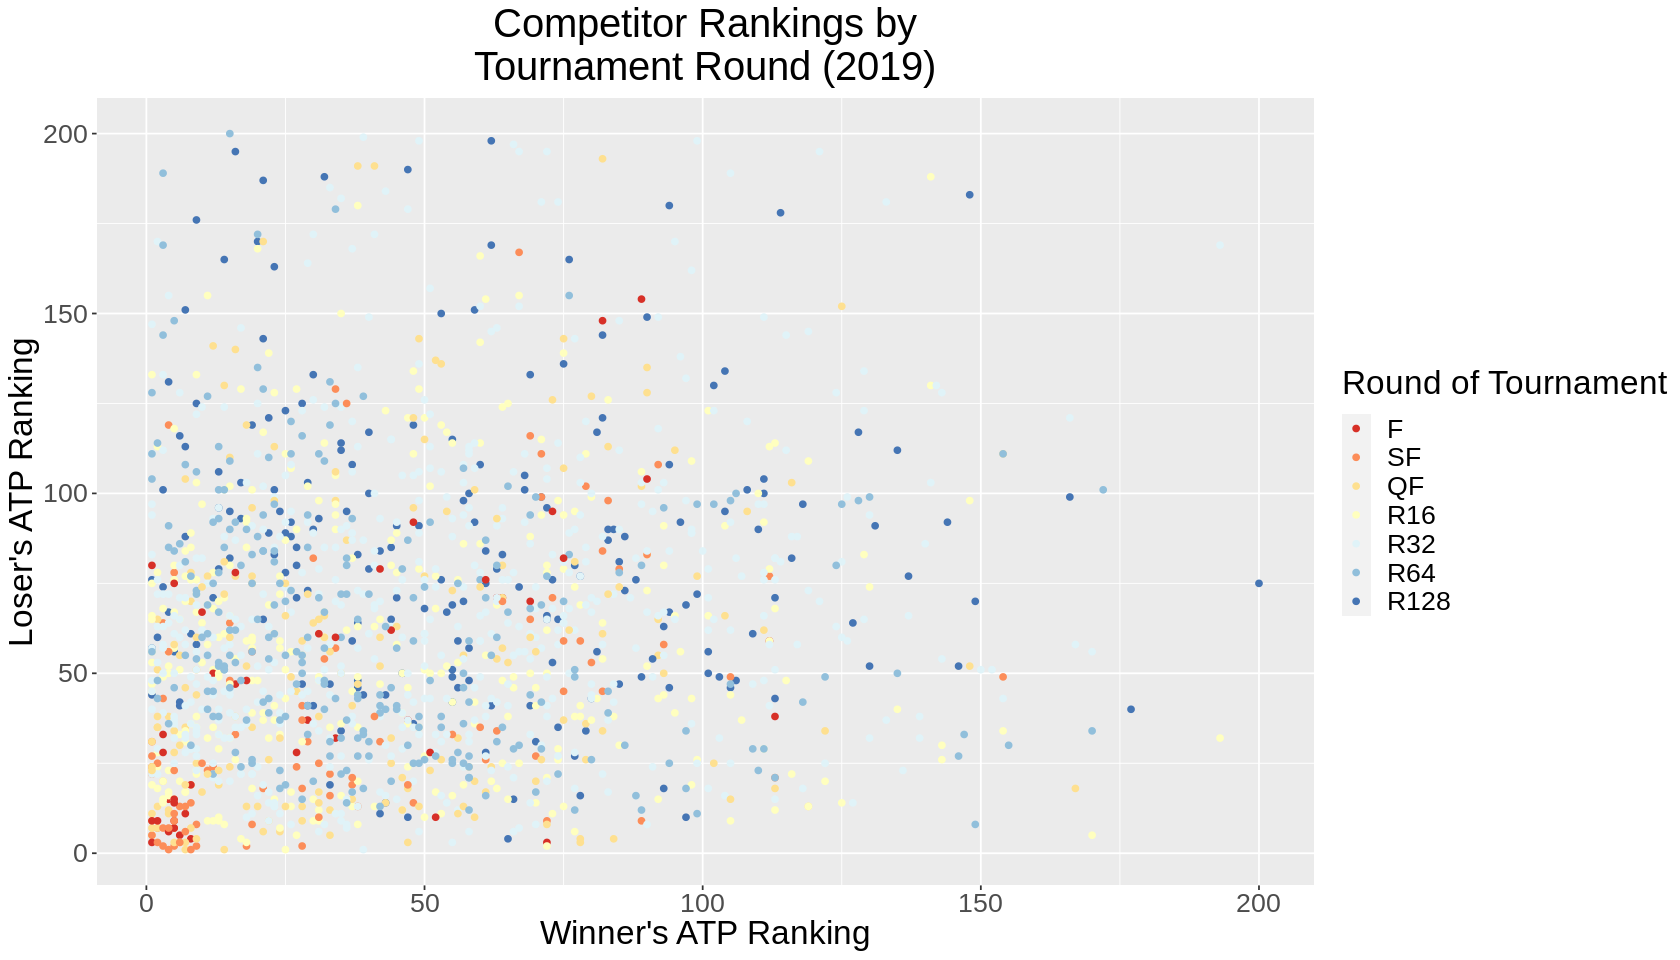

In [17]:
options(repr.plot.width = 14, repr.plot.height = 8)

matches_by_round <- tennis_train |>
    group_by(round) |>
    summarize(number_of_matches = n())

matches_by_round

matches_by_round_plot <- ggplot(matches_by_round, aes(x = round, y = number_of_matches, fill = round)) +
    geom_bar(stat = "identity") +
    labs(title = "Number of Matches by\nTournament Round (2019)",
         x = "Round of Tournament",
         y = "Number of Matches",
         fill = "Round of Tournament") +
    scale_fill_brewer(palette = "RdYlBu") +
    theme(text = element_text(size = 20),
          plot.title = element_text(hjust = 0.5))

matches_by_round_plot

rankings_vs_round_plot <- ggplot(tennis_train, aes(x = winner_rank, y = loser_rank, colour = round)) +
    geom_point() +
    labs(title = "Competitor Rankings by\nTournament Round (2019)",
         x = "Winner's ATP Ranking",
         y = "Loser's ATP Ranking",
         colour = "Round of Tournament") +
    lims(x = c(1, 200), y = c(1, 200)) +
    theme(text = element_text(size = 20),
          plot.title = element_text(hjust = 0.5)) +
    scale_color_brewer(palette = "RdYlBu")

rankings_vs_round_plot

### Methods:

The variables we are primarily concerned with using as predictors are the match participants’ ATP rankings and number of ranking points, and we are looking to predict the round of the tournament in which the match takes place.  

We will conduct our data analysis from a classification standpoint, using cross-validation to evaluate optimal model specifications and forward selection to determine which variables we will use as predictors apart from those already identified.

**Potential visualizations:** One way in which we may visualize our results would be a plot of the ratio of ranking points between the two players (winner ranking points/loser ranking points) to the round of the match, assuming that the greater the discrepancy between the players, the earlier in a tournament the match would be. Another possible visualization could be the winner’s rank plotted against the loser’s rank, coloured by the round of the match, with more advanced matches likely to be located near the origin of the plot.

### Expected outcome and significance:

**Expected findings:** We expect to find that if both of the players in a match are highly ranked and/or have a large number of points in the ATP rankings, the match will be occurring in a later round (e.g. final or semifinal). Additionally, we predict that the bigger the discrepancy between the players’ points/rankings, the earlier in the tournament the match will be due to the nature of how the tournament draws are formed.

**Potential impact:**

**Potential future questions:**
- Is there any way the ATP could make it so that the finals of tournaments include more highly-ranked players?
- Is there any way we could go a step further and predict the winner of a tournament based on the tournament draw and previous results? If not, what unconsidered factors might influence the results?
- Once we determine what the best predictor variables are for our question, will we be able to use them to predict other facts about a tournament?